# Introduction

- In the field of dentistry, the early detection and diagnosis of dental caries (commonly known as cavities) play a crucial role in preserving oral health and preventing more severe dental issues. With the advancements in machine learning and computer vision, it is now possible to leverage these technologies to develop automated systems that aid in the identification and classification of caries in oral images.

- In this project, we aim to build a machine learning model for the detection of caries in oral images. We will employ techniques such as data augmentation and regularization to enhance the model's generalization. By utilizing a dataset containing labeled images of oral scans, we will train and evaluate the model's performance in accurately classifying images as either showing signs of caries or being caries-free.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [3]:
# Set paths
train_dir = '/content/drive/MyDrive/MY_PROJECT/DL Project/tooth-decay-dataset/teeth_dataset/Trianing'
test_dir = '/content/drive/MyDrive/MY_PROJECT/DL Project/tooth-decay-dataset/teeth_dataset/test'

# Exploratory Data Analysis (EDA)

In [4]:
# Count the number of images in each class
train_caries_count = len(os.listdir(os.path.join(train_dir, 'caries')))
train_no_caries_count = len(os.listdir(os.path.join(train_dir, 'without_caries')))
test_caries_count = len(os.listdir(os.path.join(test_dir, 'caries')))
test_no_caries_count = len(os.listdir(os.path.join(test_dir, 'no-caries')))

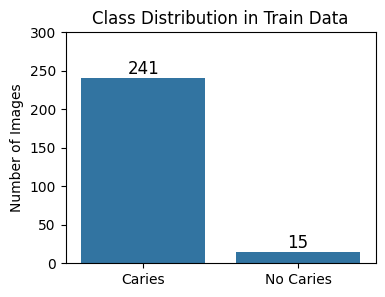

In [5]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[train_caries_count, train_no_caries_count])
plt.title('Class Distribution in Train Data')
plt.ylabel('Number of Images')
plt.ylim(0, 300)

# Add data labels to the bars
for i, count in enumerate([train_caries_count, train_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

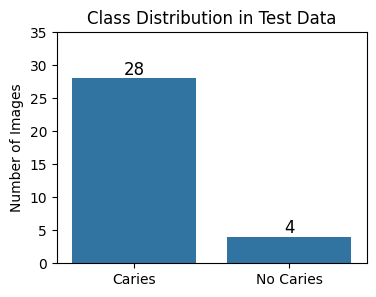

In [6]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[test_caries_count, test_no_caries_count])
plt.title('Class Distribution in Test Data')
plt.ylabel('Number of Images')
plt.ylim(0, 35)

# Add data labels to the bars
for i, count in enumerate([test_caries_count, test_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

(array([  4849.,   2770.,   3628.,   4246.,   5525.,   9029.,   9038.,
          9472.,   9138.,   9443.,  12718.,  11455.,  14239.,  16331.,
         16934.,  19239.,  22448.,  24727.,  24893.,  25320.,  31545.,
         29307.,  32396.,  33061.,  36557.,  40231.,  45166.,  49547.,
         49957.,  53184.,  75926.,  74591.,  75449.,  76297.,  71604.,
         72190.,  76231.,  89303., 102724.,  93298., 111549.,  99654.,
        101396.,  97743.,  89490.,  64500.,  58733.,  65733.,  58590.,
         46526.]),
 array([  0.        ,   5.0999999 ,  10.19999981,  15.30000019,
         20.39999962,  25.5       ,  30.60000038,  35.70000076,
         40.79999924,  45.90000153,  51.        ,  56.09999847,
         61.20000076,  66.30000305,  71.40000153,  76.5       ,
         81.59999847,  86.69999695,  91.80000305,  96.90000153,
        102.        , 107.09999847, 112.19999695, 117.30000305,
        122.40000153, 127.5       , 132.6000061 , 137.69999695,
        142.80000305, 147.8999939 , 

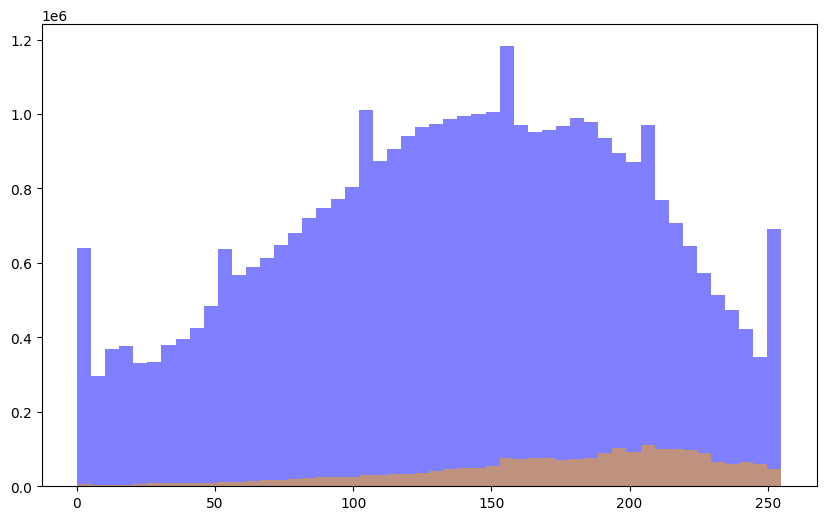

In [7]:
# Define the target image size
target_size = (224, 224)

# Load caries images as a NumPy array
caries_image_paths = [os.path.join(train_dir, 'caries', filename) for filename in os.listdir(os.path.join(train_dir, 'caries'))]
caries_images = []
for img_path in caries_image_paths:
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        caries_images.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

caries_images = np.array(caries_images)

# Load no caries images as a NumPy array
no_caries_image_paths = [os.path.join(train_dir, 'without_caries', filename) for filename in os.listdir(os.path.join(train_dir, 'without_caries'))]
no_caries_images = []
for img_path in no_caries_image_paths:
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        no_caries_images.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

no_caries_images = np.array(no_caries_images)

# Plot histograms of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(caries_images.flatten(), bins=50, color='blue', alpha=0.5, label='Caries')
plt.hist(no_caries_images.flatten(), bins=50, color='orange', alpha=0.5, label='No Caries')

## Displaying Sample Images from Each Class

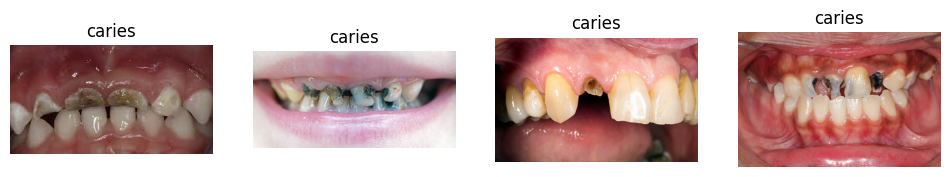

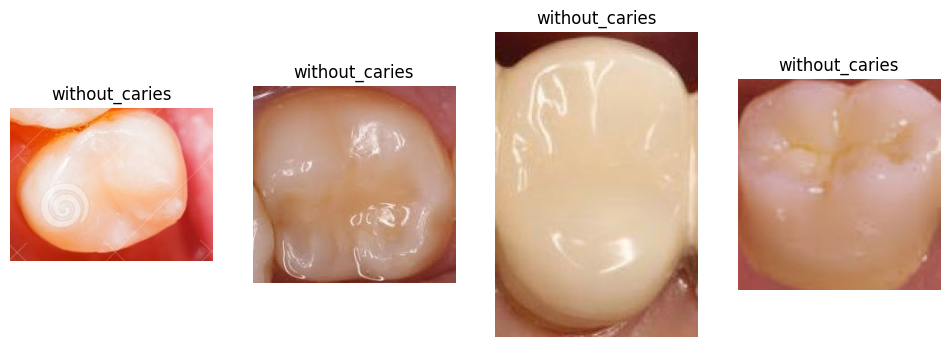

In [8]:
def display_samples(class_name, directory):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        img = Image.open(image_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_samples('caries', train_dir)
display_samples('without_caries', train_dir)

# Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 256 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


## Displaying Some Augmented Images

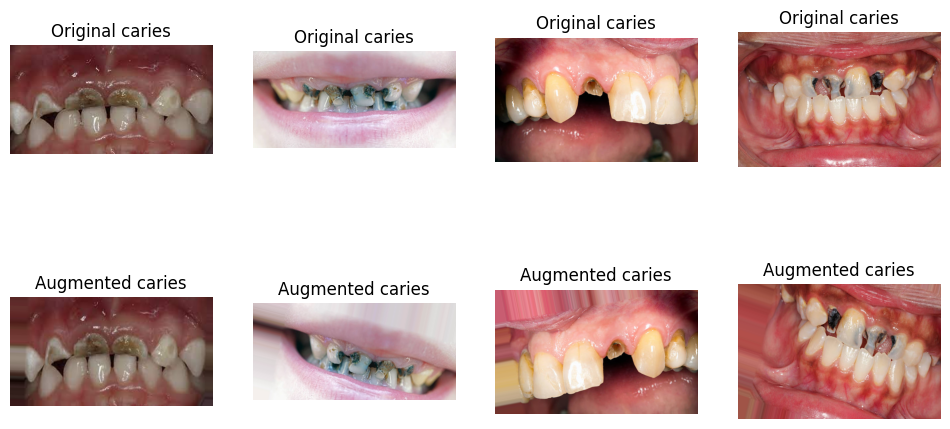

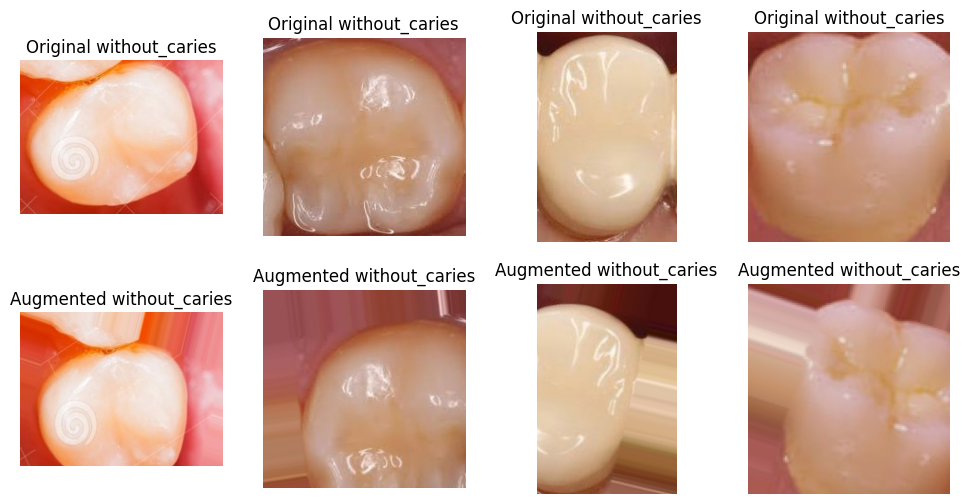

In [10]:
def display_augmented_images(class_name, directory, generator):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        original_image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        original_img = Image.open(original_image_path)

        # Convert PIL Image to NumPy array
        original_array = np.array(original_img)

        # Apply random transformation to the NumPy array
        augmented_array = generator.random_transform(original_array)

        augmented_img = Image.fromarray(augmented_array)

        plt.subplot(2, 4, i + 1)
        plt.imshow(original_img)
        plt.title(f'Original {class_name}')
        plt.axis('off')

        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented_img)
        plt.title(f'Augmented {class_name}')
        plt.axis('off')

    plt.show()

# Display augmented images for 'caries' class
display_augmented_images('caries', train_dir, train_datagen)

# Display augmented images for 'no_caries' class
display_augmented_images('without_caries', train_dir, train_datagen)

## Modeling

In [11]:
# Model with regularization
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/50
8/8 [==============================] - 22s 2s/step - loss: 21.4627 - accuracy: 0.8320 - val_loss: 16.9216 - val_accuracy: 0.8750
Epoch 2/50
8/8 [==============================] - 5s 595ms/step - loss: 8.9073 - accuracy: 0.8359 - val_loss: 13.2288 - val_accuracy: 0.8750
Epoch 3/50
8/8 [==============================] - 6s 738ms/step - loss: 6.6736 - accuracy: 0.9414 - val_loss: 7.3521 - val_accuracy: 0.8750
Epoch 4/50
8/8 [==============================] - 4s 525ms/step - loss: 4.0248 - accuracy: 0.9062 - val_loss: 3.1225 - val_accuracy: 0.8750
Epoch 5/50
8/8 [==============================] - 5s 577ms/step - loss: 2.9965 - accuracy: 0.8984 - val_loss: 2.6171 - val_accuracy: 0.8750
Epoch 6/50
8/8 [==============================] - 6s 678ms/step - loss: 2.4158 - accuracy: 0.9414 - val_loss: 2.1811 - val_accuracy: 0.8750
Epoch 7/50
8/8 [==============================] - 5s 598ms/step - loss: 1.9954 - accuracy: 0.9453 - val_loss: 1.7727 - val_accuracy: 0.8750
Epoch 8/50
8/8 [===

In [13]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

1/1 [==============================] - 0s 224ms/step - loss: 0.1678 - accuracy: 0.9062
Test accuracy: 0.91


In [14]:
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.round(predictions)

1/1 [==============================] - 0s 288ms/step


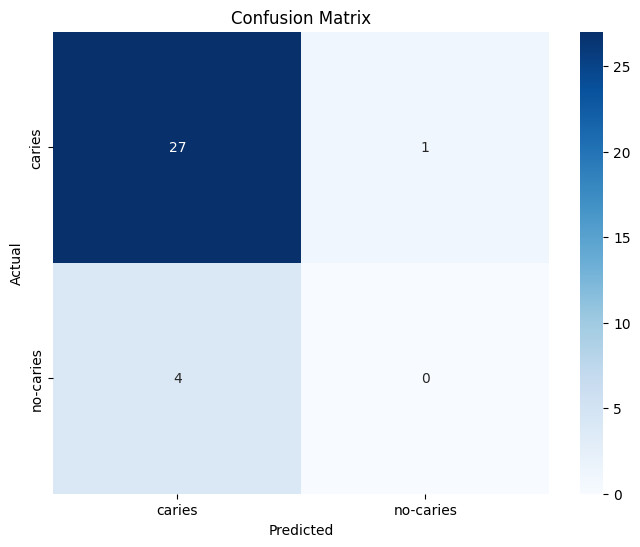

              precision    recall  f1-score   support

      caries       0.87      0.96      0.92        28
   no-caries       0.00      0.00      0.00         4

    accuracy                           0.84        32
   macro avg       0.44      0.48      0.46        32
weighted avg       0.76      0.84      0.80        32



In [15]:
# Suppress UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Remove the filter after using
warnings.filterwarnings("default", category=UndefinedMetricWarning)

Text(0.5, 1.0, 'Training and Validation Accuracy')

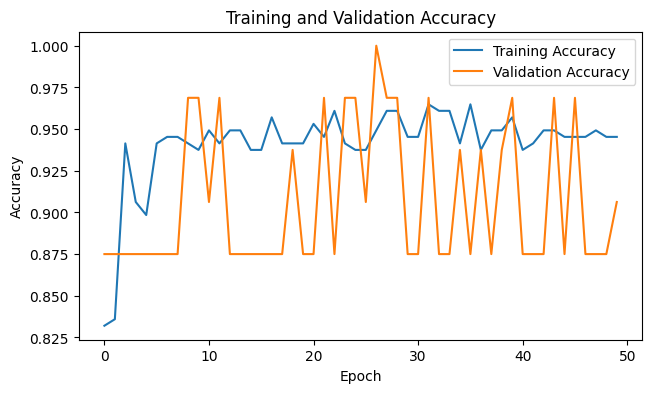

In [16]:
# Plot learning curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

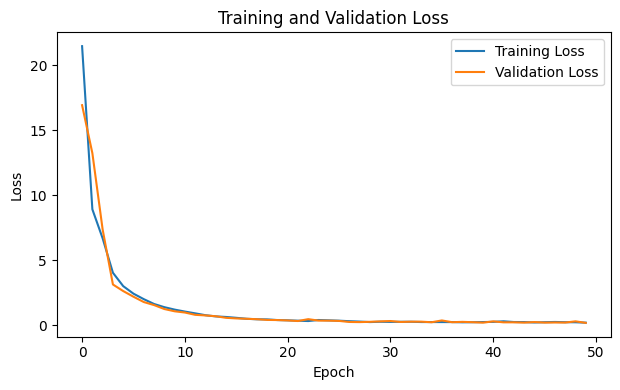

In [17]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

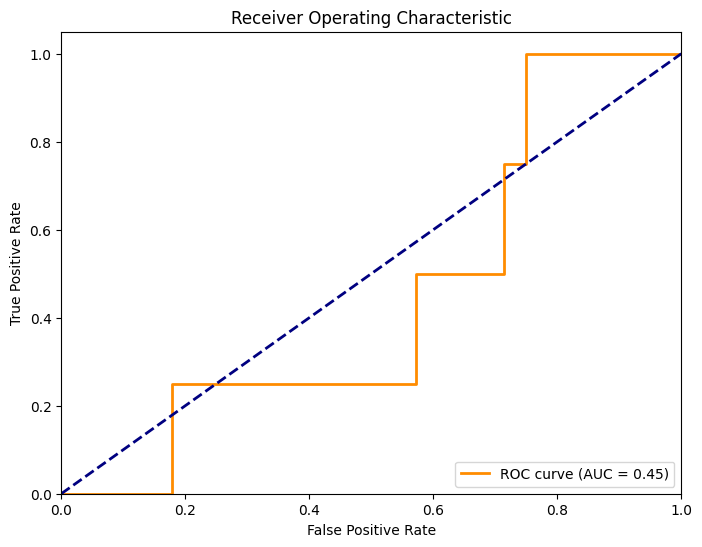

In [18]:
# Visualize ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Predicting Some Images

1/1 [==============================] - 0s 86ms/step


<ipython-input-19-504f6769de6a>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {class_names[int(true_labels[i])]}, Predicted: {class_names[int(predicted_labels[i])]}")


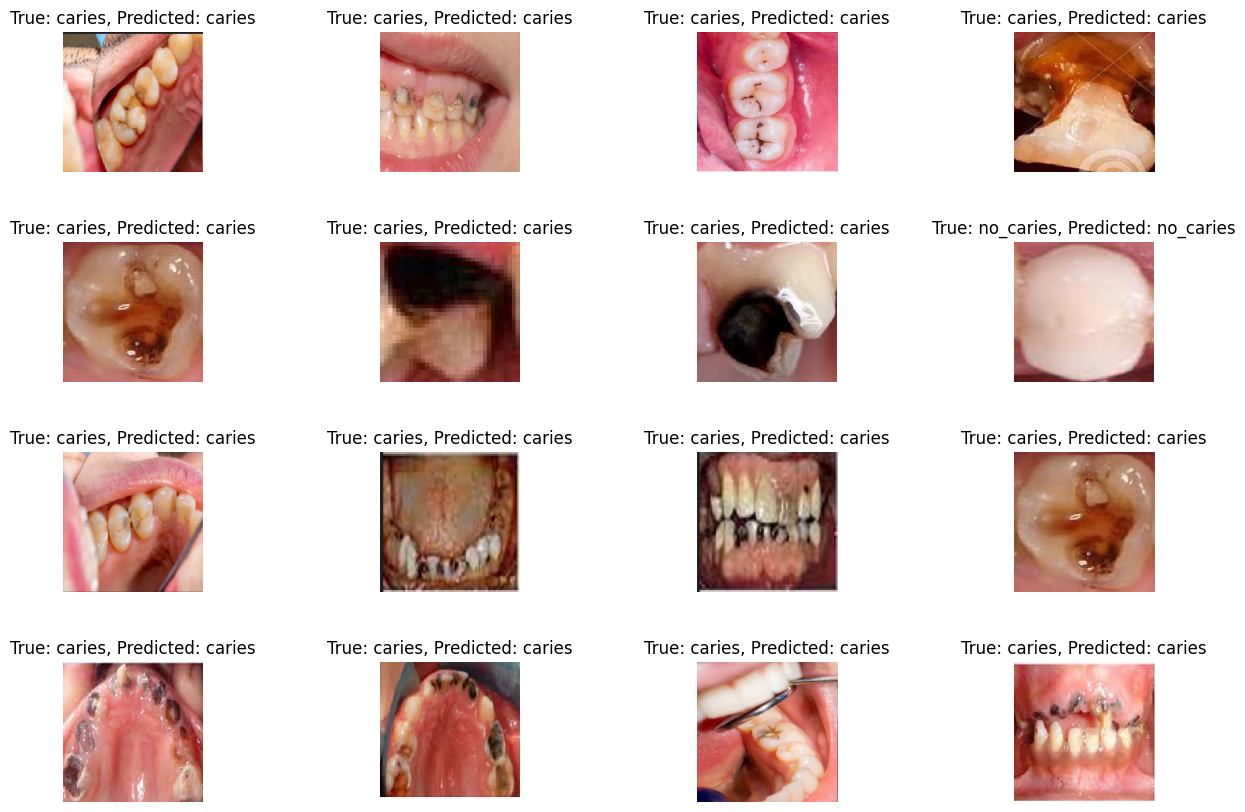

In [19]:
# Load a few test images and predict their labels
num_images_to_predict = 16  # Change this to the number of images you want to predict

# Get a few test images and their true labels
test_images, true_labels = next(test_generator)

# Predict labels for the test images
predicted_labels = model.predict(test_images)

# Convert predicted labels to binary (0 or 1)
predicted_labels = np.round(predicted_labels)

# Define class names
class_names = ['caries', 'no_caries']

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = (num_images_to_predict + num_rows - 1) // num_rows

# Display the test images along with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[int(true_labels[i])]}, Predicted: {class_names[int(predicted_labels[i])]}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
plt.show()